In [10]:
import math
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import datetime as dt

if 'a_api' in sys.modules:
    del sys.modules['a_api']
if 'learn' in sys.modules:
    del sys.modules['learn']
if 'util' in sys.modules:
    del sys.modules['util']

from learn import count_ngrams_plus, count_ngrams_plus_tf_idf
from a_api import TextMetrics

model_family = 'binary_view_cleaned'
if not os.path.exists('../../data/models/distortions/overfitting_combined/'+model_family+'/'):
    os.makedirs('../../data/models/distortions/overfitting_combined/'+model_family+'/')

grand_t0 = dt.datetime.now()

def language_metrics(metrics_list):
    metrics = {}
    for m in metrics_list:
        metrics[m] = '../../data/models/distortions/overfitting_combined/'+model_family+'/' + m + '.txt'
    return metrics

# Create Datasets
## Merge original binary and multiclass datasets into one

In [11]:
binary_dataset_file_path = "../../data/corpora/English/distortions/halilbabacan/raw_Cognitive_distortions.csv" 

import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

df1 = pd.read_csv(binary_dataset_file_path)
df1 = df1.rename(columns={'Text': 'Patient Question', 'Label': 'Dominant Distortion'})
df1.insert(1, "Distorted part", value = np.nan)
df1.insert(3, "Secondary Distortion (Optional)", value = np.nan)

df2 = pd.read_csv(multiclass_dataset_file_path) 
df2 = df2.drop('Id_Number', axis=1) # delete columnb with id 

df3 = pd.concat([df1, df2], ignore_index=True)
df3 = pd.concat([df3.iloc[:100], df3.iloc[-100:]], ignore_index=True) # hack for test
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN
...,...,...,...,...
195,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
196,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
197,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
198,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


# Create training functions
### Functions for including key N-grams and creating model files

In [12]:
def ngrams_inclusion(model_ngram, ngram_inclusion_threshold):
    filtered_model_ngram = {}
    for distortion, ngram_dict in model_ngram.items():
        # Find the maximum metric value for the current distortion
        max_value = max(ngram_dict.values()) if ngram_dict else 0
        threshold_value = max_value * (ngram_inclusion_threshold / 100)

        # Filter n-grams that meet or exceed the threshold value
        filtered_model_ngram[distortion] = {
            ngram: metric for ngram, metric in ngram_dict.items() if metric >= threshold_value
        }
    return filtered_model_ngram

def create_model_files(filtered_model_ngram):
    # Create .txt files for each distortion
    output_dir = "../../data/models/distortions/overfitting_combined/"+model_family
    distortions_labels = []

    for distortion, ngrams in filtered_model_ngram.items():
        distortion_ = distortion.replace(" ", "_")
        file_path = f"{output_dir}/{distortion_}.txt"
        sorted_ngrams = sorted(ngrams.items(), key=lambda x: x[1], reverse=True) 
        distortions_labels.append(distortion)
        with open(file_path, "w", encoding="utf-8") as f:
            for ngram, metric_value in sorted_ngrams: 
                f.write(f"{' '.join(ngram)}\t{metric_value}\n")

    return (list(set(distortions_labels) - {'No Distortion'}))

### Evaluate functions

In [13]:
def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_df_counts(df,evaluator,threshold, tm, debug=False):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
        ground_distortion = False if primary_distortion == 'No Distortion' else True
                       
        our_distortion = evaluator(text,threshold, tm)
        
        # https://en.wikipedia.org/wiki/F-score
        if ground_distortion == True and our_distortion == True:
            true_positive += 1
        if ground_distortion == False and our_distortion == True:
            false_positive += 1
        if ground_distortion == False and our_distortion == False:
            true_negative += 1
        if ground_distortion == True and our_distortion == False:
            false_negative += 1

        if debug:
            print(ground_distortion,our_distortion,text[:20],metrics)

    return true_positive, true_negative, false_positive, false_negative

def evaluate_df(df,evaluator,threshold,tm, debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return f1_from_counts(true_positive, true_negative, false_positive, false_negative)

def evaluate_df_acc_f1(df,evaluator,threshold,tm,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return (true_positive + true_negative) / len(df), f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def our_evaluator(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    if metrics.get('Distortion', 0) > threshold:
        return True
    return False

### Functions for analyzing the dataset and plot heatmaps

In [14]:
def matrix_plot(row_labels, col_labels, matrix, absmax, title=None, subtitle=None, vmin=None, vmax=None, dpi=None, titlefontsize=None, subtitlefontsize=None, width=20):
    plt.rcParams["figure.figsize"] = (width, len(row_labels) / 4)
    if dpi is not None:
        plt.rcParams["figure.dpi"] = dpi

    fig, ax = plt.subplots()

    p = sns.heatmap(matrix, ax=ax, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin=-absmax if vmin is None else vmin, 
                    vmax=absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        ax.set_title(title, fontsize=titlefontsize, pad=20)

    if subtitle is not None:
        if subtitlefontsize is None:
            subtitlefontsize = round(titlefontsize * 0.7)
        ax.text(0.5, 1.01, subtitle, fontsize=subtitlefontsize, ha='center', va='bottom', transform=ax.transAxes)

    plt.show()


def analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, df, print_or_plot):

    if print_or_plot == 'print_results':
        print('\nN-gram selection metric:', ngram_selection_metric)
        print('N-gram max length:', ngram_max)
        print('N-gram inclusion threshold:', ngram_inclusion_threshold)

    if ngram_selection_metric == 'TF-IDF':
        model_ngram = count_ngrams_plus_tf_idf(df,ngram_max,binary=True)
    if ngram_selection_metric in ['F','UF','FN','UFN','UFN/D/D','FN*UFN','FN*UFN/D','CFR','FCR','MR','NLMI']:
        distortions, frequency, all_n_grams, frequency_self_normalized, unique_frequency, uniq_all_n_grams, n_gram_distortions, \
            norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, unique_frequency_self_normalized, norm_norm_uniq, norm_norm_uniq_norm, \
            norm_norm_uniq_norm_norm, fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df,ngram_max,binary=True)
        selection_metrics = {
            'F':frequency,
            'UF':unique_frequency,
            'FN':frequency_self_normalized,
            'UFN':unique_frequency_self_normalized,
            'UFN/D/D':norm_uniq_n_gram_dicts,
            'FN*UFN':norm_norm_uniq,
            'FN*UFN/D':norm_norm_uniq_norm,
            'CFR':cfr,
            'FCR':fcr,
            'MR':mr,
            'NLMI':nl_mi}
        model_ngram = selection_metrics[ngram_selection_metric]

    # Filter out values below the threshold
    filtered_model_ngram = ngrams_inclusion(model_ngram, ngram_inclusion_threshold)

    # Create .txt files for each distortion
    distortions_labels = create_model_files(filtered_model_ngram)
    tm = TextMetrics(language_metrics(distortions_labels), encoding = "utf-8", debug=False)

    if print_or_plot == 'print_results':
        print('\tDetection threshold, accuracy, F1 score:')
    any_res_acc = {}
    any_res = {}
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        acc, f1 = evaluate_df_acc_f1(df3,our_evaluator,threshold, tm)
        any_res_acc[threshold] = acc
        any_res[threshold] = f1
        if print_or_plot == 'print_results':
            print('\t', threshold, acc, f1)

    min_acc = min(any_res_acc.values())
    max_acc = max(any_res_acc.values())
    avg_acc = sum(any_res_acc.values()) / len(any_res_acc)

    min_f1 = min(any_res.values())
    max_f1 = max(any_res.values())
    avg_f1 = sum(any_res.values()) / len(any_res)

    if print_or_plot == 'print_results':
        print(f"\nAccuracy: min={min_acc}, max={max_acc}, avg={avg_acc}")
        print(f"F1 Score: min={min_f1}, max={max_f1}, avg={avg_f1}")
    
    return any_res_acc

# Grid search
### Perform a grid search over all hyper-parameters to determine the best combination for building the model

In [15]:
ngram_selection_metrics = ['TF-IDF','F','UF','FN','UFN','UFN/D/D','FN*UFN','FN*UFN/D','CFR','FCR','MR','NLMI']
ngram_max_values = [1, 2, 3, 4]
ngram_inclusion_thresholds = [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]

for ngram_selection_metric in ngram_selection_metrics:
    for ngram_max in ngram_max_values:
        for ngram_inclusion_threshold in ngram_inclusion_thresholds:
            acc_data = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, df3, 'print_results')


N-gram selection metric: TF-IDF
N-gram max length: 1
N-gram inclusion threshold: 90
	Detection threshold, accuracy, F1 score:
	 0.1 0.495 0.6505190311418686
	 0.2 0.5 0.647887323943662
	 0.3 0.55 0.6484375
	 0.4 0.58 0.6283185840707965
	 0.5 0.425 0.3979057591623037
	 0.6 0.29 0.13414634146341461
	 0.7 0.235 0
	 0.8 0.235 0
	 0.9 0.235 0

Accuracy: min=0.235, max=0.58, avg=0.3938888888888889
F1 Score: min=0, max=0.6505190311418686, avg=0.34524605997578284

N-gram selection metric: TF-IDF
N-gram max length: 1
N-gram inclusion threshold: 80
	Detection threshold, accuracy, F1 score:
	 0.1 0.605 0.7538940809968847
	 0.2 0.61 0.7562499999999999
	 0.3 0.6 0.7452229299363057
	 0.4 0.595 0.7254237288135594
	 0.5 0.545 0.5919282511210763
	 0.6 0.365 0.29050279329608936
	 0.7 0.25 0.038461538461538464
	 0.8 0.235 0
	 0.9 0.235 0

Accuracy: min=0.235, max=0.61, avg=0.4488888888888889
F1 Score: min=0, max=0.7562499999999999, avg=0.433520369180606

N-gram selection metric: TF-IDF
N-gram max length

### Our best model obtained through the optimal combination of hyper-parameters

In [16]:
# Best model
acc_data = analyse_dataset('FN', 3, 90, df3, 'print_results')


N-gram selection metric: FN
N-gram max length: 3
N-gram inclusion threshold: 90
	Detection threshold, accuracy, F1 score:
	 0.1 0.995 0.9967426710097721
	 0.2 1.0 1.0
	 0.3 1.0 1.0
	 0.4 1.0 1.0
	 0.5 1.0 1.0
	 0.6 1.0 1.0
	 0.7 1.0 1.0
	 0.8 1.0 1.0
	 0.9 1.0 1.0

Accuracy: min=0.995, max=1.0, avg=0.9994444444444444
F1 Score: min=0.9967426710097721, max=1.0, avg=0.9996380745566413


# Plot heatmaps 
## Plot heatmaps illustrating the search for optimal hyperparameters

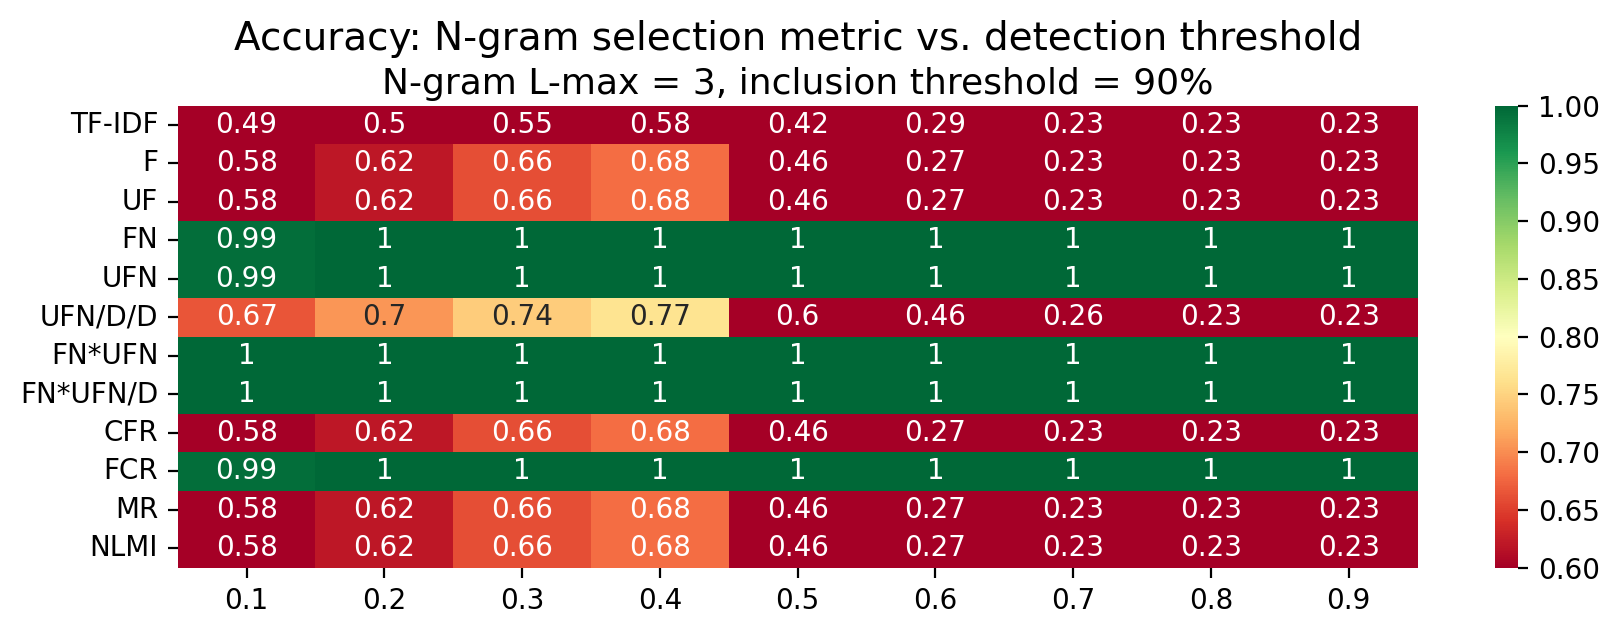

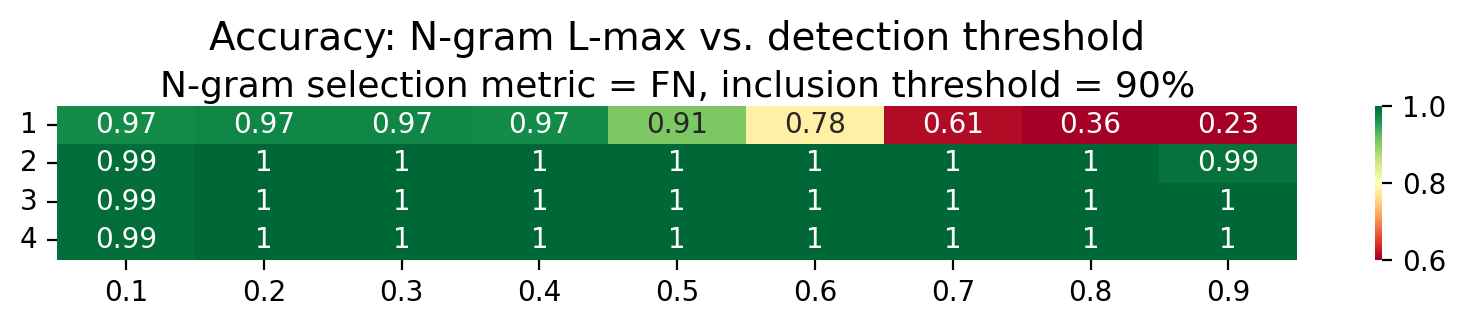

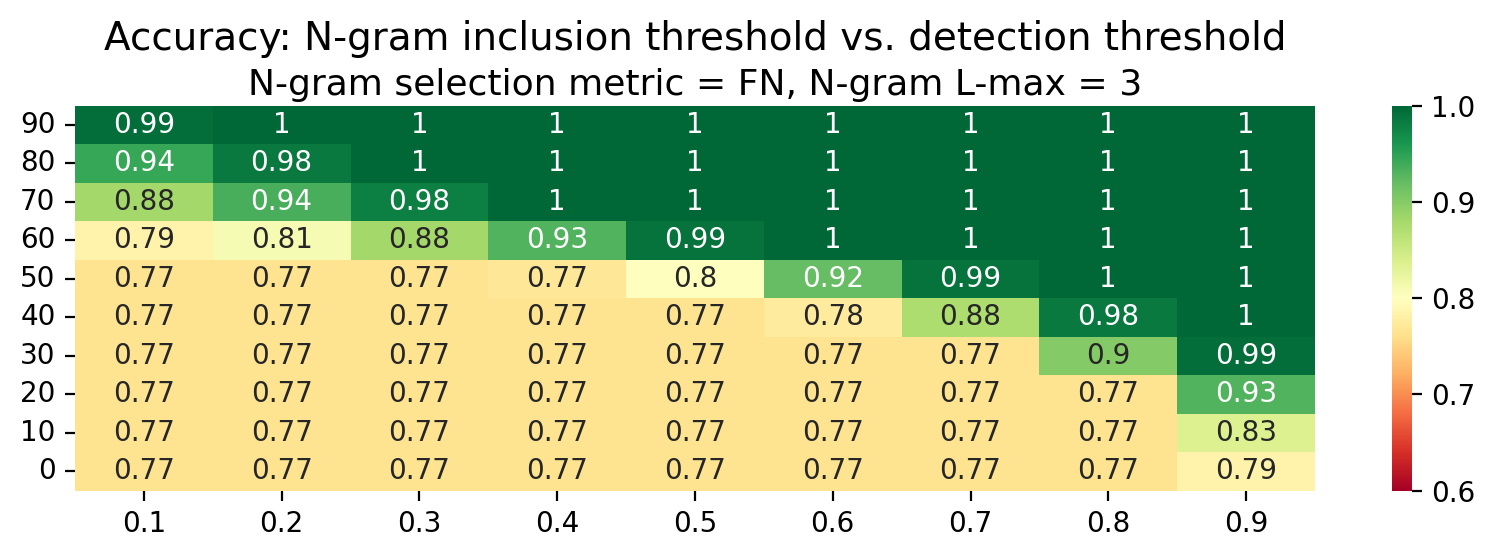

In [17]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# 1) N-gram selection metric - threshold
acc_analytics_threshold = np.zeros((len(ngram_selection_metrics), len(thresholds)))
for i, ngram_selection_metric in enumerate(ngram_selection_metrics):
    acc_data = analyse_dataset(ngram_selection_metric, 3, 90, df3, 'plot_results')
    for j, threshold in enumerate(thresholds):
        acc_analytics_threshold[i, j] = acc_data[threshold]

matrix_plot(
    ngram_selection_metrics, thresholds, acc_analytics_threshold, 1.0,
    title="Accuracy: N-gram selection metric vs. detection threshold",
    subtitle="N-gram L-max = 3, inclusion threshold = 90%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)


# 2) ngram_max - threshold
acc_ngrammax_threshold = np.zeros((len(ngram_max_values), len(thresholds)))
for i, ngram_max in enumerate(ngram_max_values):
    acc_data = analyse_dataset('FN', ngram_max, 90, df3, 'plot_results')
    for j, threshold in enumerate(thresholds):
        acc_ngrammax_threshold[i, j] = acc_data[threshold]

matrix_plot(
    ngram_max_values, thresholds, acc_ngrammax_threshold, 1.0,
    title="Accuracy: N-gram L-max vs. detection threshold",
    subtitle="N-gram selection metric = FN, inclusion threshold = 90%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)

            
# 3) ngram_inclusion_threshold - threshold
acc_ngram_inclusion_threshold = np.zeros((len(ngram_inclusion_thresholds), len(thresholds)))

for i, ngram_inclusion_threshold in enumerate(ngram_inclusion_thresholds):
    acc_data = analyse_dataset('FN', 3, ngram_inclusion_threshold, df3, 'plot_results')
    for j, threshold in enumerate(thresholds):
        acc_ngram_inclusion_threshold[i, j] = acc_data[threshold]

matrix_plot(
    ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold, 1.0,
    title="Accuracy: N-gram inclusion threshold vs. detection threshold",
    subtitle="N-gram selection metric = FN, N-gram L-max = 3",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)

In [18]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'0:08:57.464336'